#Analyzing NYC subway data

This project look at the NYC Subway data and figure out if more people ride the subway when it is raining versus when it is not raining.

The data can be found at:

* Original data set at: https://www.dropbox.com/s/meyki2wl9xfa7yk/turnstile_data_master_with_weather.csv
* Improved data set at: https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0

Now that we have the data to work with we can start analyzing the data.

## Statistical Analysis

In [1]:
%matplotlib inline

import numpy as np
import pandas
import matplotlib.pyplot as plt

In [3]:
df = pandas.read_csv('turnstile_data_master_with_weather.csv')

Before we perform any analysis, it might be useful to take a
look at the data we're hoping to analyze. More specifically, let's 
examine the hourly entries in our NYC subway data and determine what
distribution the data follows.

In [4]:
with_rain_df = df['ENTRIESn_hourly'][df['rain'] == 0]
without_rain_df = df['ENTRIESn_hourly'][df['rain'] == 1]

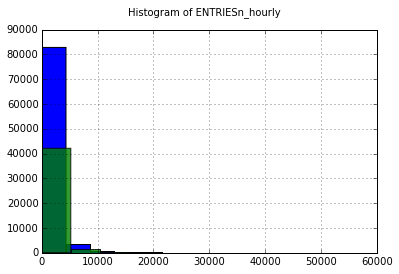

In [5]:
figure = plt.figure()
figure.suptitle('Histogram of ENTRIESn_hourly')

with_rain_plot = with_rain_df.hist()
without_rain_plot = without_rain_df.hist(alpha=0.8)

Next we look at some descriptive statistice regarding these two samples.

In [6]:
with_rain_df.describe()

count    87847.000000
mean      1090.278780
std       2320.004938
min          0.000000
25%         38.000000
50%        278.000000
75%       1111.000000
max      43199.000000
Name: ENTRIESn_hourly, dtype: float64

In [7]:
without_rain_df.describe()

count    44104.000000
mean      1105.446377
std       2370.527674
min          0.000000
25%         41.000000
50%        282.000000
75%       1103.250000
max      51839.000000
Name: ENTRIESn_hourly, dtype: float64

### Statistical test, tail and null hypothesis

We will perform Mann-Whitney U test on the two samples. We will be performing a one-tail P value with .05 p-critical value, with the following hypothesis:

**The Null hypothesis**:

entries-raining-day = entries-non-raining-day

**The alternative hypothesis**:

entries-raining-day < entries-non-raining-day

### Statistical test reasoning
We are using this test because we don't want to make any asssumption on the underlying distribution but the shape of the distribution is the same.

### Result
Below we compute the result:

In [8]:
import scipy.stats

U, p = scipy.stats.mannwhitneyu(with_rain_df, without_rain_df)
print "U :", U
print "p :", p

U : 1924409167.0
p : 0.0249999127935


We can see that the p < .05.

### Interpretation

We find a statistically significant different between number of entry when it is raining versus when it is not raining. This results are significant at the .05 level.

## Linear Regression

Now let's build a model so we can make predictions.

### Approach
To compute the coefficients theta and produce prediction for ENTRIESn_hourly in the regression model I choose to 
use OLS using Statsmodels.

We will implement 3 helper function here:

* A function that does linear regression,
* A function that calculate R^2. We need this to check on our result and,
* A function that generate list of prediction value based on data and list of features

In [16]:
import statsmodels.api as sm

def linear_regression(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features.
    """    
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    
    intercept, params = results.params[0], results.params[1:]
    return intercept, params

def compute_r_squared(data, predictions):
    '''
    Compute r_squared given a data set and the predictions.
    '''
    
    data_mean = np.mean(data)
    ss_res = ((data - predictions)**2).sum()
    ss_tot = ((data - data_mean)**2).sum()
    r_squared = 1 - (ss_res/ss_tot)
    
    return r_squared

def calculate_predictions(dataframe, features):
    '''
    Generate prediction given dataframe and features.
    '''
    
    # Add UNIT to features using dummy variables
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)

    # Values
    values = dataframe['ENTRIESn_hourly']

    # Get the numpy arrays
    features_array = features.values
    values_array = values.values

    # Perform linear regression
    intercept, params = linear_regression(features_array, values_array)

    predictions = intercept + np.dot(features_array, params)

    return predictions

### Features

We will try to compute the prediction for several possible features.
Please check the code below for the features.
We aim to have R^2 score of 0.40 or better.

The features of interest are:
 
* rain
* meantempi
* fog
* meanwindspi
* precipi
* Hour

We will create a combination out of these feature, compute the predictions and get the R^2 value.

In [34]:
from itertools import combinations

# Build our features list combination
feature_of_interest = ['rain', 'meantempi', 'fog', 'meanwindspdi', 'precipi', 'Hour']
features_list = []
for count in range(1, len(feature_of_interest) + 1):
    for item in combinations(feature_of_interest, count):
        features_list.append(list(item))

print "{:40s} {:10s}".format('Features', 'R^2')
for features in features_list:
    predictions = calculate_predictions(df, df[features])
    r2_score = compute_r_squared(df['ENTRIESn_hourly'], predictions)
    feature_name = ', '.join(features)
    print "{:40s} {:<10f}".format(feature_name, r2_score)
    

Features                                 R^2       
rain                                     0.418351  
meantempi                                0.418796  
fog                                      0.418461  
meanwindspdi                             0.418975  
precipi                                  0.418413  
Hour                                     0.457549  
rain, meantempi                          0.418796  
rain, fog                                0.418453  
rain, meanwindspdi                       0.418982  
rain, precipi                            0.418426  
rain, Hour                               0.457561  
meantempi, fog                           0.418964  
meantempi, meanwindspdi                  0.419152  
meantempi, precipi                       0.418823  
meantempi, Hour                          0.458001  
fog, meanwindspdi                        0.419142  
fog, precipi                             0.418477  
fog, Hour                                0.457671  
meanwindspdi

We will use the last features in our list. That is rain, precipi, Hour, meantempi, meanpressurei.

Let's try to make a histogram of the residuals
(that is, the difference between the original hourly entry data and the predicted values).

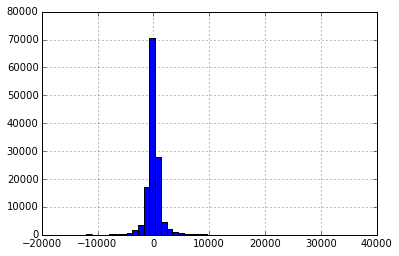

In [28]:
plt.figure()
(df['ENTRIESn_hourly'] - predictions).hist(bins=50)

We see that the plot of residuals approximate normal distribution.
This is what we expected since residuals is a form of error,
so the same general assumptions apply to the group of residuals that we typically use for errors in general: one expects them to be (roughly) normal and (approximately) independently distributed with a mean of 0 and some constant variance.

## Visualization

## Conclusions